In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
#from stage_1_model_v1 import *
import stage_1_util_v1
from parse_lsp_extend_data import *

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
from crop_image import *

In [3]:
from drawLines_v2 import drawLines

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11383987747633815379
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15768014029
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12293030862710172529
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [5]:
import stage_1_modelClass_v1 as s1
import stage_s_modelClass_v1 as ss
tfe.enable_eager_execution()

In [6]:
train_list, train_label, val_list, val_label, test_list, test_label = getLSPExtendDataset(0.9, 0.05)
train_X = train_list	# (N, 227, 227, 3)
train_Y = train_label	# (N, 2, 14)
print("train X: ", train_list.shape, "val X: ", val_list.shape, "test X: ", test_list.shape)
print("train Y: ", train_label.shape, "val Y: ", val_label.shape, "test Y: ", test_label.shape)

Resizing and packing images and labels to lists.

Start to process training dataset
Done processing the training dataset
Start to process validation dataset
Done processing the validation dataset
Start to process test dataset
Done processing the test dataset
train X:  (9000, 227, 227, 3) val X:  (500, 227, 227, 3) test X:  (500, 227, 227, 3)
train Y:  (9000, 2, 14) val Y:  (500, 2, 14) test Y:  (500, 2, 14)


In [10]:
train_X = train_list
train_Y = train_label

n_samples = train_Y.shape[0] # N
val_n = val_label.shape[0]
n_joints = train_Y.shape[2]
n_stage = 3

# Parameters
learning_rate = 0.00005
batch_size = 128
display_step = 1
epochs = 250
thresh = 0.5

if n_samples % batch_size == 0:
    n_batch = int(n_samples / batch_size)
else:
    n_batch = int(n_samples / batch_size) + 1

if val_n % batch_size == 0:
    val_n_batch = int(val_n / batch_size)
else:
    val_n_batch = int(val_n / batch_size) + 1

In [11]:
def loss(model, inputs, targets, stage, is_training = True, b_array = None, prev_predictions = None):
    #print(inputs)
    if stage == 1:
        predictions = model.predict(inputs, is_training) # (N, 2, 14) in original scale
    else:
        predictions = model.predict(inputs, is_training, b_array, prev_predictions)
    #print(predictions_1)
    #inputs_2, b_array_1 = images_crop(inputs, predictions_1, targets)    # inputs_2 (N, 227, 227, 3*14), b_array_1 (N, 14)
    #predictions_2 = model2.predict(inputs_2, is_training, b_array_1, predictions_1)
    #inputs_3, b_array_2, _, _ = images_crop(inputs, predictions_2, targets)
    #predictions_3 = model3.predict(inputs_3, is_training, b_array_2, predictions_2)
    loss = tf.reduce_sum(tf.square(predictions - targets))
    return loss

In [12]:
def get_loss_acc(targets, predictions, torsor_frac):
    joint_diff = tf.square(targets - predictions)
    joint_dist = tf.sqrt(tf.reduce_sum(joint_diff, axis = 1))   # (N, 2, 14) -> (N, 14)
    loss = tf.reduce_sum(joint_diff)
    accuracy = tf.reduce_sum(tf.to_int32(tf.greater(torsor_frac, joint_dist))) * 1.0 / (int(joint_dist.shape[0]) * int(joint_dist.shape[1]))
    return loss.numpy(), accuracy.numpy()

In [13]:
def loss_accuracy_1(model, inputs, targets, thresh, is_training):
    torsor_xy = targets[:, :, 9] - targets[:, :, 2] #distance left_shoulder <-> right_hip in xy, result (N, 2)
    torsor_dist = tf.sqrt(tf.reduce_sum(tf.square(torsor_xy), axis = 1, keep_dims = True)) # distance scaler, (N, 2) -> (N)
    torsor_frac = torsor_dist * thresh # max error distance

    predictions = model.predict(inputs, is_training) # (N, 2, 14) in original scale
    loss, accuracy = get_loss_acc(targets, predictions, torsor_frac)
    
    return loss, accuracy

In [14]:
def loss_accuracy_s(model, inputs, targets, thresh, prev_pred, b_array, is_training):
    torsor_xy = targets[:, :, 9] - targets[:, :, 2] #distance left_shoulder <-> right_hip in xy, result (N, 2)
    torsor_dist = tf.sqrt(tf.reduce_sum(tf.square(torsor_xy), axis = 1, keep_dims = True)) # distance scaler, (N, 2) -> (N)
    torsor_frac = torsor_dist * thresh # max error distance

    inputs = tf.convert_to_tensor(inputs, np.float32)
    predictions = model.predict(inputs, is_training, b_array, prev_pred)
    loss, accuracy = get_loss_acc(targets, predictions, torsor_frac)

    #inputs_3, b_array_2, _, _ = images_crop(inputs, predictions_2, targets)
    #predictions_3 = model3.predict(inputs_3, is_training, b_array_2, predictions_2)
    #loss_3, accuracy_3 = get_loss_acc(targets, predictions_3, torsor_frac)
    #return loss_1, loss_2, loss_3, accuracy_1, accuracy_2, accuracy_3
    return loss, accuracy

In [15]:
def next_batch_XY(batch, batch_size, X, Y):
    if batch < n_batch - 1:
        batch_X = X[batch * batch_size: (batch + 1) * batch_size, :, :, :]
        batch_Y = Y[batch * batch_size: (batch + 1) * batch_size, :, :]
    else:
        batch_X = X[batch * batch_size:, :, :, :]
        batch_Y = Y[batch * batch_size:, :, :]
    batch_X = tf.convert_to_tensor(batch_X, np.float32)
    batch_Y = tf.convert_to_tensor(batch_Y, np.float32)
    #print(batch_X.shape, batch_Y.shape)
    return batch_X, batch_Y

In [16]:
def next_batch_bp(batch, batch_size, X, Y):
    if batch < n_batch - 1:
        batch_X = X[batch * batch_size: (batch + 1) * batch_size, :, :]
        batch_Y = Y[batch * batch_size: (batch + 1) * batch_size, :, :]
    else:
        batch_X = X[batch * batch_size:, :, :]
        batch_Y = Y[batch * batch_size:, :, :]
    batch_X = tf.convert_to_tensor(batch_X, np.float32)
    batch_Y = tf.convert_to_tensor(batch_Y, np.float32)
    #print(batch_X.shape, batch_Y.shape)
    return batch_X, batch_Y

In [17]:
def shuffle(X, Y):
    image_indexes = list(range(Y.shape[0]))
    np.random.shuffle(image_indexes)
    train_X_new = X[np.asarray(image_indexes)]
    train_Y_new = Y[np.asarray(image_indexes)]
    #print(image_indexes)
    #print(train_X_new[:, 0, :, :])
    #print(train_Y_new[:, 0, :])
    return train_X_new, train_Y_new

In [18]:
model1 = s1.stage_1_model(n_joints)
model2 = ss.stage_s_model(n_joints)
model3 = ss.stage_s_model(n_joints)

In [19]:
# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In [20]:
# Compute gradients
grad = tfe.implicit_gradients(loss)

In [21]:
# Training
# is_training = False for no dropout
tr_costs_1 = []
tr_costs_2 = []
val_cost_1 = []
val_cost_2 = []
train_acc_list_1 = []
train_acc_list_2 = []
val_acc_list_1 = []
val_acc_list_2 = []
loss_incr_max = 0.0
params = stage_1_util_v1.params
train_X_s, train_Y_s = train_X, train_Y

In [23]:
tr_X = train_list.astype(np.float32)
tr_Y = train_label.astype(np.float32)
val_X = val_list.astype(np.float32)
val_Y = val_label.astype(np.float32)
for epoch in range(5):
    with tf.device('/device:GPU:0'):
        batch_cost_1 = 0.0

        train_X_s, train_Y_s = shuffle(train_X_s, train_Y_s)

        for batch in range(n_batch):
            batch_X, batch_Y = next_batch_XY(batch, batch_size, train_X_s, train_Y_s)
            optimizer.apply_gradients(grad(model1, batch_X, batch_Y, 1))
            batch_cost_1 += loss(model1, batch_X, batch_Y, 1)

        batch_cost_1 = batch_cost_1 / n_samples
        tr_costs_1.append(batch_cost_1)
        if epoch % display_step == 0:
            print("Stage: 1, Epoch:", epoch, "cost", batch_cost_1.numpy())
            
        tr_acc_1 = 0.0
        for batch in range(n_batch):
            batch_X, batch_Y = next_batch_XY(batch, batch_size, tr_X, tr_Y)
            _, cur_tr_acc_1 = loss_accuracy_1(model1, batch_X, batch_Y, thresh, False)
            tr_acc_1 += cur_tr_acc_1 * int(batch_X.shape[0])
        tr_acc_1 /= int(tr_X.shape[0])
        print("train accuracy 1: ", tr_acc_1)
        train_acc_list_1.append(tr_acc_1)
        val_loss_1, val_acc_1 = loss_accuracy_1(model1, val_X, val_Y, thresh, False)
        val_acc_list_1.append(val_acc_1)
        val_loss_1 /= int(val_Y.shape[0])
        val_cost_1.append(val_loss_1)
        print("val loss 1: ", val_loss_1, "val accuracy 1: ", val_acc_1)
with tf.device('/device:GPU:0'):    
    val_predictions_1 = model1.predict(val_X, is_training = False)
    val_inputs_2, val_b_array_1 = images_crop(val_X, val_predictions_1, val_Y)

for epoch in range(3):
    with tf.device('/device:GPU:0'):
        batch_cost_2 = 0.0

        for batch in range(n_batch):
            print("epoch: ", epoch, "batch: ", batch)
            batch_X_1, batch_Y_1 = next_batch_XY(batch, batch_size, tr_X, tr_Y)
            predictions_1 = model1.predict(batch_X_1, is_training = False)
            inputs_2, b_array_1 = images_crop(batch_X_1, predictions_1, batch_Y_1)
            inputs_2 = tf.convert_to_tensor(inputs_2, np.float32)

            optimizer.apply_gradients(grad(model2, inputs_2, batch_Y_1, 2, True, b_array_1, predictions_1))
            batch_cost_2 += loss(model2, inputs_2, batch_Y_1, 2, True, b_array_1, predictions_1)
        batch_cost_2 = batch_cost_2 / n_samples
        tr_costs_2.append(batch_cost_2)
        if epoch % display_step == 0:
            print("Stage: 2, Epoch:", epoch, "cost", batch_cost_2.numpy())
            
        tr_acc_2 = 0.0
        for batch in range(n_batch):
            print("train, ", batch)
            batch_X_1, batch_Y_1 = next_batch_XY(batch, batch_size, tr_X, tr_Y)
            predictions_1 = model1.predict(batch_X_1, is_training = False)
            inputs_2, b_array_1 = images_crop(batch_X_1, predictions_1, batch_Y_1)
            _, cur_tr_acc_2 = loss_accuracy_s(model2, inputs_2, batch_Y_1, thresh, predictions_1, b_array_1, False)
            tr_acc_2 += cur_tr_acc_2 * int(batch_X_1.shape[0])
        tr_acc_2 /= int(tr_X.shape[0])
        print("train accuracy 2: ", tr_acc_2)
        train_acc_list_2.append(tr_acc_2)
        
        val_acc_2 = 0.0
        val_loss_2 = 0.0
        for batch in range(val_n_batch):
            print("val, ", batch)
            val_batch_X, val_batch_Y = next_batch_XY(batch, batch_size, val_inputs_2, val_Y)
            val_batch_b_array_1, val_batch_predictions_1 = next_batch_bp(batch, batch_size, val_b_array_1, val_predictions_1)
            print(val_batch_X.shape)
            cur_val_loss_2, cur_val_acc_2 = loss_accuracy_s(model2, val_batch_X, val_batch_Y, thresh, val_batch_predictions_1, val_batch_b_array_1, False)
            val_acc_2 += cur_val_acc_2 * int(val_batch_X.shape[0])
            val_loss_2 += cur_val_loss_2
        val_acc_2 /= int(val_Y.shape[0])
        val_acc_list_2.append(val_acc_2)
        val_loss_2 /= int(val_Y.shape[0])
        val_cost_2.append(val_loss_2)
        print("val loss 2: ", val_loss_2, "val accuracy 2: ", val_acc_2)

Stage: 1, Epoch: 0 cost 105739.47
train accuracy 1:  0.27770634920634935
val loss 1:  93479.6 val accuracy 1:  0.2784285714285714
Stage: 1, Epoch: 1 cost 94559.5
train accuracy 1:  0.2845079365079366
val loss 1:  91514.912 val accuracy 1:  0.28514285714285714
Stage: 1, Epoch: 2 cost 91845.23
train accuracy 1:  0.25284920634920643
val loss 1:  93437.456 val accuracy 1:  0.25685714285714284
Stage: 1, Epoch: 3 cost 90340.09
train accuracy 1:  0.3012460317460319
val loss 1:  88608.224 val accuracy 1:  0.2988571428571429
Stage: 1, Epoch: 4 cost 88837.11
train accuracy 1:  0.3132142857142858
val loss 1:  89439.728 val accuracy 1:  0.30857142857142855
epoch:  0 batch:  0
epoch:  0 batch:  1
epoch:  0 batch:  2
epoch:  0 batch:  3
epoch:  0 batch:  4
epoch:  0 batch:  5
epoch:  0 batch:  6
epoch:  0 batch:  7
epoch:  0 batch:  8
epoch:  0 batch:  9
epoch:  0 batch:  10
epoch:  0 batch:  11
epoch:  0 batch:  12
epoch:  0 batch:  13
epoch:  0 batch:  14
epoch:  0 batch:  15
epoch:  0 batch:  16


KeyboardInterrupt: 

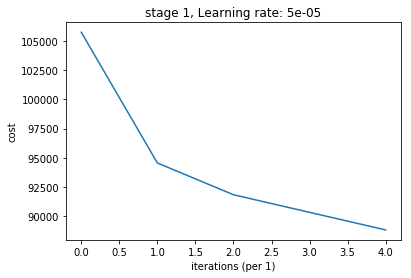

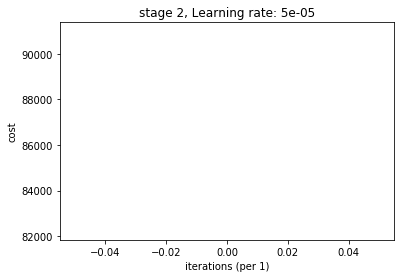

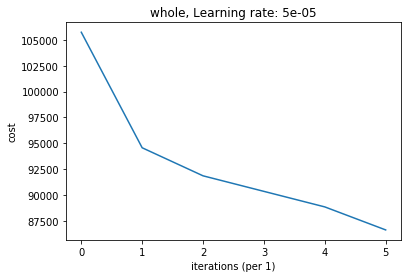

In [41]:
fig = plt.figure()
plt.plot(range(len(tr_costs_1)), np.squeeze(tr_costs_1), label = "train")
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("stage 1, Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost_1.png')
plt.show()

fig = plt.figure()
plt.plot(range(len(tr_costs_2)), np.squeeze(tr_costs_2), label = "train")
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("stage 2, Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost_2.png')
plt.show()

tr_costs_whole = tr_costs_1 + tr_costs_2
fig = plt.figure()
plt.plot(range(len(tr_costs_whole)), np.squeeze(tr_costs_whole), label = "train")
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("whole, Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost_12.png')
plt.show()

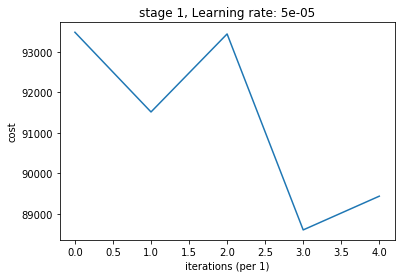

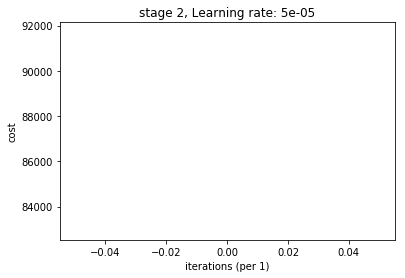

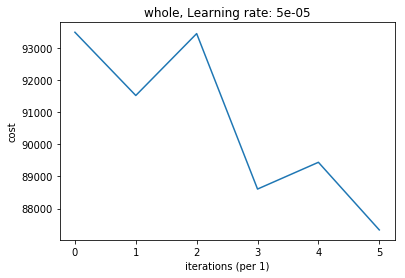

In [60]:
fig = plt.figure()
plt.plot(range(len(val_cost_1)), np.squeeze(val_cost_1), label = "train")
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("stage 1, Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost_1_val.png')
plt.show()

fig = plt.figure()
plt.plot(range(len(val_cost_2)), np.squeeze(val_cost_2), label = "train")
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("stage 2, Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost_2_val.png')
plt.show()

val_costs_whole = val_cost_1 + val_cost_2
fig = plt.figure()
plt.plot(range(len(val_costs_whole)), np.squeeze(val_costs_whole), label = "train")
plt.ylabel('cost')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("whole, Learning rate: " + str(learning_rate))
fig.savefig('AlexNet_cost_12_val.png')
plt.show()

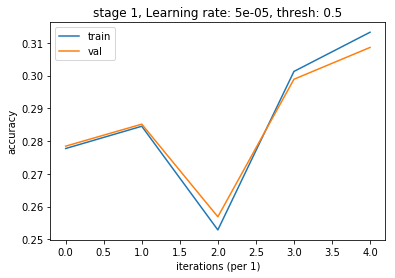

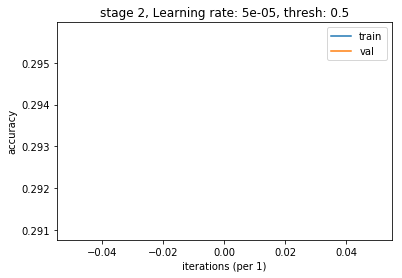

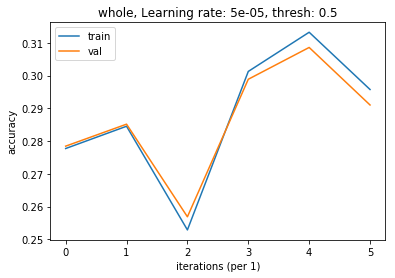

In [42]:
fig = plt.figure()
plt.plot(range(len(val_acc_list_1)), np.squeeze(train_acc_list_1), label = "train")
plt.plot(range(len(val_acc_list_1)), np.squeeze(val_acc_list_1), label = "val")
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("stage 1, Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_accuracy_1.png')
plt.show()

fig = plt.figure()
plt.plot(range(len(val_acc_list_2)), np.squeeze(train_acc_list_2), label = "train")
plt.plot(range(len(val_acc_list_2)), np.squeeze(val_acc_list_2), label = "val")
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("stage 2, Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_accuracy_2.png')
plt.show()

tr_acc_whole = train_acc_list_1 + train_acc_list_2
val_acc_whole = val_acc_list_1 + val_acc_list_2
fig = plt.figure()
plt.plot(range(len(tr_acc_whole)), np.squeeze(tr_acc_whole), label = "train")
plt.plot(range(len(tr_acc_whole)), np.squeeze(val_acc_whole), label = "val")
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('iterations (per %d)' %display_step)
plt.title("whole, Learning rate: " + str(learning_rate) + ", thresh: " + str(thresh))
fig.savefig('AlexNet_accuracy_12.png')
plt.show()

In [56]:
with tf.device('/device:GPU:0'):
    one = train_list[2, :, :, :]
    one_1 = tf.convert_to_tensor(one, np.float32)
    one_1 = tf.reshape(one_1, [1, one_1.shape[0], one_1.shape[1], one_1.shape[2]])
    predictions_1 = model1.predict(one_1, False) # (N, 2, 14) in original scale
    inputs_2, b_array_1 = images_crop(one_1, predictions_1, train_label[0, :, :])    # inputs_2 (N, 227, 227, 3*14), b_array_1 (N, 14)
    inputs_2 = tf.convert_to_tensor(inputs_2, np.float32)
    predictions_2 = model2.predict(inputs_2, False, b_array_1, predictions_1)
    print(predictions_2)
    print(train_label[2, :, :])

tf.Tensor(
[[[ 99.72585  103.72719   90.81224   93.12983  109.23654  105.69361
    95.93364   94.30165   97.63277  103.01613  110.58493  111.78752
    87.901474 111.42221 ]
  [102.26863   96.83991   79.11938   74.85874   94.23628  101.5033
    83.91627   80.49591   73.98667   70.52249   77.25356   83.65015
    65.26747   75.18588 ]]], shape=(1, 2, 14), dtype=float32)
[[  0.           0.           0.           0.           0.
    0.          88.8585022   91.37336547  89.26631786   0.
  126.58145124 145.02378189   0.           0.        ]
 [-37.66905755 -37.66905755 -37.66905755 -37.66905755 -37.66905755
  -37.66905755 108.39648     73.83135279  46.49868464 -37.66905755
   76.63393067 112.31406198 -37.66905755 -37.66905755]]


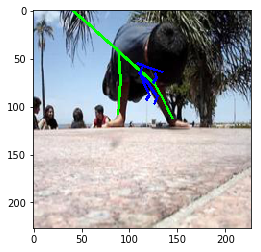

In [55]:
drawLines(train_list[2].copy(),train_label[2].copy(),predictions_2[0])

In [45]:
with tf.device('/device:GPU:0'):
    one = val_list[0, :, :, :]
    one_1 = tf.convert_to_tensor(one, np.float32)
    one_1 = tf.reshape(one_1, [1, one_1.shape[0], one_1.shape[1], one_1.shape[2]])
    predictions_1 = model1.predict(one_1, False) # (N, 2, 14) in original scale
    inputs_2, b_array_1 = images_crop(one_1, predictions_1, val_label[0, :, :])    # inputs_2 (N, 227, 227, 3*14), b_array_1 (N, 14)
    inputs_2 = tf.convert_to_tensor(inputs_2, np.float32)
    predictions_2 = model2.predict(inputs_2, False, b_array_1, predictions_1)
    print(predictions_2)
    print(val_label[0, :, :])

tf.Tensor(
[[[118.10165  121.37028  110.182335 119.809555 129.84328  126.054726
   113.24947  111.1323   113.46649  127.0244   128.16095  125.978424
   108.63304  134.59628 ]
  [ 93.73729   88.761635  65.24211   75.375946  90.168785  97.61035
    69.9837    65.22923   59.982166  66.51314   70.58873   75.76473
    55.970215  64.242325]]], shape=(1, 2, 14), dtype=float32)
[[137.48554732 124.08704359 171.55516605 -37.81154319 143.06825721
  -37.81154319 150.31069166 -37.81154319 -37.81154319 176.02133396
  131.32947804 108.99863848 173.21489061 188.30329572]
 [ 51.83718111  81.9361895   64.78517796   0.          94.477443
    0.         115.37953215   0.           0.         108.69086362
  108.26152341 118.29452621 119.55994999 136.68836467]]


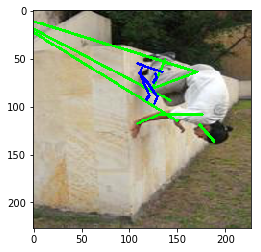

In [46]:
drawLines(val_list[0].copy(),val_label[0].copy(),predictions_2[0])

In [ ]:
# Below are discarded functions. Keep them just records

def loss(model1, model2, model3, inputs, targets, is_training = True):
    predictions_1 = model1.predict(inputs, is_training) # (N, 2, 14) in original scale
    #print(predictions_1)
    inputs_2, b_array_1 = images_crop(inputs, predictions_1, targets)    # inputs_2 (N, 227, 227, 3*14), b_array_1 (N, 14)
    predictions_2 = model2.predict(inputs_2, is_training, b_array_1, predictions_1)
    #inputs_3, b_array_2, _, _ = images_crop(inputs, predictions_2, targets)
    #predictions_3 = model3.predict(inputs_3, is_training, b_array_2, predictions_2)
    loss = tf.reduce_sum(tf.square(predictions_2 - targets))
    return loss


def loss_accuracy(model1, model2, model3, inputs, targets, thresh, is_training):
    torsor_xy = targets[:, :, 9] - targets[:, :, 2] #distance left_shoulder <-> right_hip in xy, result (N, 2)
    torsor_dist = tf.sqrt(tf.reduce_sum(tf.square(torsor_xy), axis = 1, keep_dims = True)) # distance scaler, (N, 2) -> (N)
    torsor_frac = torsor_dist * thresh # max error distance

    predictions_1 = model1.predict(inputs, is_training) # (N, 2, 14) in original scale
    loss_1, accuracy_1 = get_loss_acc(targets, predictions_1, torsor_frac)

    inputs_2, b_array_1 = images_crop(inputs, predictions_1, targets)    # inputs_2 (N, 227, 227, 3*14), b_array_1 (N, 14)
    predictions_2 = model2.predict(inputs_2, is_training, b_array_1, predictions_1)
    loss_2, accuracy_2 = get_loss_acc(targets, predictions_2, torsor_frac)

    #inputs_3, b_array_2, _, _ = images_crop(inputs, predictions_2, targets)
    #predictions_3 = model3.predict(inputs_3, is_training, b_array_2, predictions_2)
    #loss_3, accuracy_3 = get_loss_acc(targets, predictions_3, torsor_frac)
    #return loss_1, loss_2, loss_3, accuracy_1, accuracy_2, accuracy_3
    return loss_1, loss_2, 0, accuracy_1, accuracy_2, 0


for epoch in range(epochs):
   # with tf.device('/device:GPU:0'):
    batch_cost = 0.0

    train_X_s, train_Y_s = shuffle(train_X_s, train_Y_s)

    for batch in range(n_batch):
        #print("epoch: ", epoch, "batch: ", batch)
        batch_X, batch_Y = next_batch(batch, batch_size, train_X_s, train_Y_s)
        #if batch == 0 and epoch == 0:
            #ini_loss = loss(model, batch_X, batch_Y, is_training = True).numpy() / int(batch_Y.shape[0])
            #print('initial loss: ', ini_loss)
        #pred = stage_1_model(batch_X, n_joints, is_training, params) # (N, 2, # joints)
        #optimizer.apply_gradients(grad(model1, model2, model3, batch_X, batch_Y))
        #batch_cost += loss(model1, model2, model3, batch_X, batch_Y, is_training = True)
        optimizer.apply_gradients(grad(model1, model2, model3, batch_X, batch_Y))
        batch_cost += loss(model1, model2, model3, batch_X, batch_Y, is_training = True)

    batch_cost = batch_cost / n_samples
    costs.append(batch_cost)
    #if epoch > 2:
    #    incre = ((costs[-1] - costs[-2]) / costs[-2]).numpy()
    #    print('loss increase percent: ', incre)
    #    if incre > loss_incr_max:
    #        loss_incr_max = incre

    if epoch % display_step == 0:
        print("Epoch:", epoch, "cost", batch_cost.numpy())

    tr_X = tf.convert_to_tensor(train_list, np.float32)
    tr_Y = tf.convert_to_tensor(train_label, np.float32)
    #_, _, _, tr_acc_1, tr_acc_2, tr_acc_3 = loss_accuracy(model1, model2, model3, tr_X, tr_Y, thresh, is_training = False)
    _, _, _, tr_acc_1, tr_acc_2, tr_acc_3 = loss_accuracy(model1, model2, model3, tr_X, tr_Y, thresh, is_training = False)
    print("train accuracy 1: ", tr_acc_1, "train accuracy 2: ", tr_acc_2, "train accuracy 2: ", tr_acc_3)
    train_acc_list.append(tr_acc_3)
    val_X = tf.convert_to_tensor(val_list, np.float32)
    val_Y = tf.convert_to_tensor(val_label, np.float32)
    #val_loss_1, val_loss_2, val_loss_3, val_acc_1, val_acc_2, val_acc_3 = loss_accuracy(model1, model2, model3, val_X, val_Y, thresh, is_training = False)
    val_loss_1, val_loss_2, val_loss_3, val_acc_1, val_acc_2, val_acc_3 = loss_accuracy(model1, model2, model3, val_X, val_Y, thresh, is_training = False)
    val_acc_list.append(val_acc_3)
    val_loss_3 /= int(val_Y.shape[0])
    print("val loss: ", val_loss_3, "val accuracy: ", val_acc_3)

    
    
    
    
    
    

#with tf.device('/device:GPU:0'):
#tr_X = tf.convert_to_tensor(train_list, np.float32)
#tr_Y = tf.convert_to_tensor(train_label, np.float32)
#val_X = tf.convert_to_tensor(val_list, np.float32)
#val_Y = tf.convert_to_tensor(val_label, np.float32)

tr_X = train_list.astype(np.float32)
tr_Y = train_label.astype(np.float32)
val_X = val_list.astype(np.float32)
val_Y = val_label.astype(np.float32)
for epoch in range(50):
    with tf.device('/device:GPU:0'):
        #print(epoch)
        batch_cost_1 = 0.0

        train_X_s, train_Y_s = shuffle(train_X_s, train_Y_s)

        for batch in range(n_batch):
            #print("epoch: ", epoch, "batch: ", batch)
            batch_X, batch_Y = next_batch_XY(batch, batch_size, train_X_s, train_Y_s)
            #if batch == 0 and epoch == 0:
                #ini_loss = loss(model, batch_X, batch_Y, is_training = True).numpy() / int(batch_Y.shape[0])
                #print('initial loss: ', ini_loss)
            #pred = stage_1_model(batch_X, n_joints, is_training, params) # (N, 2, # joints)
            #optimizer.apply_gradients(grad(model1, model2, model3, batch_X, batch_Y))
            #batch_cost += loss(model1, model2, model3, batch_X, batch_Y, is_training = True)
            optimizer.apply_gradients(grad(model1, batch_X, batch_Y, 1))
            batch_cost_1 += loss(model1, batch_X, batch_Y, 1)
            #batch_cost += loss(model1, batch_X, batch_Y, is_training = True)

        batch_cost_1 = batch_cost_1 / n_samples
        costs_1.append(batch_cost_1)
        if epoch % display_step == 0:
            print("Stage: 1, Epoch:", epoch, "cost", batch_cost_1.numpy())

        _, tr_acc_1 = loss_accuracy_1(model1, tr_X, tr_Y, thresh, False)
        print("train accuracy 1: ", tr_acc_1)
        train_acc_list_1.append(tr_acc_1)
        val_loss_1, val_acc_1 = loss_accuracy_1(model1, val_X, val_Y, thresh, False)
        val_acc_list_1.append(val_acc_1)
        val_loss_1 /= int(val_Y.shape[0])
        print("val loss 1: ", val_loss_1, "val accuracy 1: ", val_acc_1)
with tf.device('/device:GPU:0'):
    predictions_1 = model1.predict(tr_X, is_training = False)
    inputs_2, b_array_1 = images_crop(tr_X, predictions_1, tr_Y)
    
    val_predictions_1 = model1.predict(val_X, is_training = False)
    val_inputs_2, val_b_array_1 = images_crop(val_X, val_predictions_1, val_Y)

for epoch in range(50):
    #print(epoch)
    with tf.device('/device:GPU:0'):
        batch_cost_2 = 0.0

        #train_X_s, train_Y_s = shuffle(train_X_s, train_Y_s)

        for batch in range(n_batch):
            print("epoch: ", epoch, "batch: ", batch)
            batch_X, batch_Y = next_batch_XY(batch, batch_size, inputs_2, tr_Y)
            batch_b_array_1, batch_predictions_1 = next_batch_bp(batch, batch_size, b_array_1, predictions_1)
            #if batch == 0 and epoch == 0:
                #ini_loss = loss(model, batch_X, batch_Y, is_training = True).numpy() / int(batch_Y.shape[0])
                #print('initial loss: ', ini_loss)
            #pred = stage_1_model(batch_X, n_joints, is_training, params) # (N, 2, # joints)
            #optimizer.apply_gradients(grad(model1, model2, model3, batch_X, batch_Y))
            #batch_cost += loss(model1, model2, model3, batch_X, batch_Y, is_training = True)
            #print(batch_b_array_1.shape)
            optimizer.apply_gradients(grad(model2, batch_X, batch_Y, 2, True, batch_b_array_1, batch_predictions_1))
            batch_cost_2 += loss(model2, batch_X, batch_Y, 2, True, batch_b_array_1, batch_predictions_1)
        batch_cost_2 = batch_cost_2 / n_samples
        costs_2.append(batch_cost_2)
        if epoch % display_step == 0:
            print("Stage: 2, Epoch:", epoch, "cost", batch_cost_2.numpy())
            
        tr_acc_2 = 0.0
        for batch in range(n_batch):
            batch_X, batch_Y = next_batch_XY(batch, batch_size, inputs_2, tr_Y)
            batch_b_array_1, batch_predictions_1 = next_batch_bp(batch, batch_size, b_array_1, predictions_1)
            
            _, cur_tr_acc_2 = loss_accuracy_s(model2, batch_X, batch_Y, thresh, batch_predictions_1, batch_b_array_1, False)
            tr_acc_2 += cur_tr_acc_2 * int(batch_X.shape[0])
        tr_acc_2 /= int(inputs_2.shape[0])
        print("train accuracy 2: ", tr_acc_2)
        train_acc_list_2.append(tr_acc_2)
        val_loss_2, val_acc_2 = loss_accuracy_s(model2, val_inputs_2, val_Y, thresh, val_predictions_1, val_b_array_1, False)
        val_acc_list_2.append(val_acc_2)
        val_loss_2 /= int(val_Y.shape[0])
        print("val loss 2: ", val_loss_2, "val accuracy 2: ", val_acc_2)